In [169]:
import math
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.io as sio

from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback, ModelCheckpoint


In [170]:
def plot_roc(df_test_out, preds):
    # Results ROC
    fpr, tpr, thresholds = roc_curve(df_test_out, preds)
    roc_score = roc_auc_score(df_test_out, preds)
    plt.figure(figsize=(10,5))
    plt.grid(color='#919191', linestyle=':', linewidth=1)
    plt.plot(fpr, tpr, label='MPL')
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Decisão aleatória')
    plt.title('Curva ROC')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    plt.legend()
    plt.show()
    print("ROC Score", roc_score)

In [167]:
def plot_history(history):
    # plot training history
    plt.figure(figsize=(10,5))
    plt.grid(color='#919191', linestyle=':', linewidth=1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.grid(True)
    plt.legend()
    plt.show()

In [148]:
# Read and build DataFrames
df_test = sio.loadmat('dados_teste.mat')
df_train = sio.loadmat('dados_treinamento.mat')
df_val = sio.loadmat('dados_val.mat')

df_test = pd.DataFrame(np.concatenate((df_test['Xt'], df_test['yt']), axis=1),columns=['x1', 'x2', 'y'])
df_train = pd.DataFrame(np.concatenate((df_train['X'], df_train['y']), axis=1),columns=['x1', 'x2', 'y'])
df_val = pd.DataFrame(np.concatenate((df_val['Xval'], df_val['yval']), axis=1),columns=['x1', 'x2', 'y'])

# Data normalization and encoding
scaler = StandardScaler()
df_train_out = df_train.loc[:,'y'].replace(-1, 0)
df_train_inp = df_train.drop('y', axis=1)
scaler.fit(df_train_inp) 

df_train_inp_scaled = scaler.transform(df_train_inp)

df_val_out = df_val.loc[:,'y'].replace(-1, 0)
df_val_inp = df_val.drop('y', axis=1)
df_val_inp_scaled = scaler.transform(df_val_inp)


df_test_out = df_test.loc[:,'y'].replace(-1, 0)
df_test_inp = df_test.drop('y', axis=1)
df_test_inp_scaled = scaler.transform(df_test_inp)




In [164]:
# MLP
neuron_num = 20
mlp_weight = 'mlp_weight_ne'+str(neuron_num)
callbacks = [
    ModelCheckpoint(mlp_weight, monitor='val_loss', save_best_only=True, verbose=0),
]
model = Sequential()
model.add(Dense(neuron_num, input_dim=2))
model.add(Activation('tanh'))
model.add(Dropout(0.15))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [172]:
# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
if os.path.isfile(mlp_weight):
    model.load_weights(mlp_weight)
print("Training...")
history = model.fit(\
    df_train_inp, df_train_out, validation_data=(df_val_inp, df_val_out),callbacks=callbacks,\
    epochs=500, batch_size=10, verbose=0, shuffle=True, use_multiprocessing=True)
print('Predicting...')
preds = model.predict(df_test_inp, verbose=1)

Training...
Predicting...
1000/1000 [==============================] - 0s 32us/step


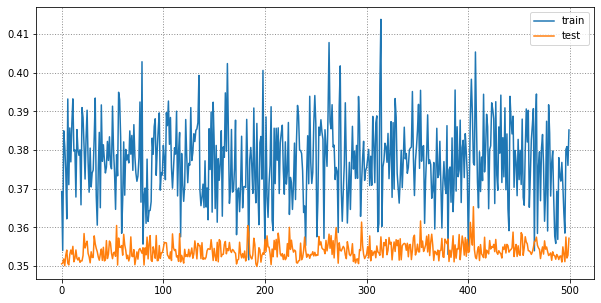

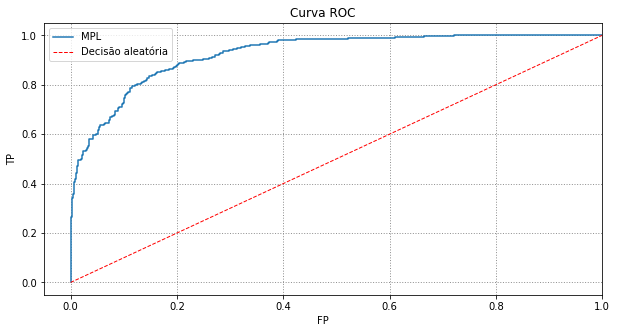

ROC Score 0.924675698702795


In [173]:
plot_history(history)
plot_roc(df_test_out, preds)